In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *

from RiverSwim import *
from CurriculumPPO import CurriculumPPO

In [2]:
#River Swim Environment
nS = 150
uniform_restart = True
num_runs = 3


small = 5e-3
large = 1.
nA = 2
gamma = 0.999

original_mu = np.zeros(nS)
original_mu[1] = 1
if uniform_restart:
    mu = np.ones(nS) / nS
else:
    mu = original_mu

xi = np.ones(nS) * 1/nS

episodes = 9000000
checkpoint_step=500
test_episodes = 10000
discount_tau = True
param_decay=True
debug = False

lam = 1
experiment_results = []
tests_returns = []
tests_lens = []
exp_taus = []

In [3]:
tau = 0.5
pol_lr = 0.3153456231864957
model_lr = 0.07600227185743516
temp = 5

entropy_coef = 0.0010124439030950623
epochs = 3
batch_size = 32
final_temp=1e-3

eps_ppo = 0.2
eps_model = compute_eps_model(gamma, tau, episodes/10)


In [4]:

run_name = f"CurrPPO_{uniform_restart}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"RiverSwim_{nS}_{uniform_restart}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [5]:
def run_experiment(index, seed, run_name):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        
        # Environment specific configuration   
        set_policy_seed(seed)
        env = RiverSwim(nS, mu, small=small, large=large, seed=seed)
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, 
                    gamma=gamma, discount_tau=discount_tau, 
                    seed=seed)
        tmdp.update_tau(tau)
        
        curr_PPO = CurriculumPPO(tmdp, checkpoint_step=checkpoint_step)

        curr_PPO.train(model_lr, pol_lr, batch_size=batch_size, 
                lam=lam, temp=temp, final_temp=final_temp,
                episodes=episodes, eps_ppo=eps_ppo,
                eps_model=eps_model,
                param_decay=param_decay, epochs=epochs, max_length=1000,
                entropy_coef=entropy_coef, debug=debug)
        
        
        avg_return = np.average(curr_PPO.reward_records[-10:])/batch_size
        
        mlflow.log_metric("Avg Return", avg_return)
        
        test_policies = test_policies_len(tmdp, curr_PPO.thetas, test_episodes, 1e-10, mu=original_mu)
        test_policies_return = test_policies[0]
        test_pol_len = test_policies[1]
        
        result_dict = {
            "thetas" : curr_PPO.thetas,
            "taus" : curr_PPO.taus,
            "reward_records" : curr_PPO.reward_records,
            "test_policies_return" : test_policies_return,
            "index" : index,
            "test_pol_len" : test_pol_len,
        }

        tests_returns.append(test_policies_return)
        experiment_results.append(result_dict)
        tests_lens.append(test_pol_len)
        exp_taus.append(curr_PPO.taus)
        

In [6]:
def run_experiments(num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name)
        
        pad_results = pad_to_same_length(tests_returns)
        pad_lens = pad_to_same_length(tests_lens)
        pad_taus = pad_to_same_length(exp_taus)
        experiment_dict = {
            "tests_returns": pad_results,
            "taus": pad_taus,
            "tests_lens": pad_lens,
            "num_runs": num_runs,
            "label": label,
            "checkpoint_step": checkpoint_step,
            "uniform_restart": uniform_restart,
        }

        mlflow.set_tags(tags={
            "seed": seed,
            "tau": tau,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "episodes": episodes,
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "temp": temp,
            "final_temp": final_temp,
            "batch_size": batch_size,
            "epochs": epochs,
            "lam": lam,
            "eps_ppo": eps_ppo,
            "eps_model": eps_model,
            "entropy_coef": entropy_coef,
            "param_decay": param_decay,
            "discount_tau": discount_tau,
            "uniform_restart": uniform_restart,
            "small": small,
            "large": large,
        })

        try:
            save_to_mlflow(experiment_dict)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_returns, f"{run_name[:-3]} Avg Return on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

Current seed for result reproducibility: 2999
Episode: 5000 reward: 0.5149999999999998 tau 0.49978444468395034
Episode: 10000 reward: 1.0129364995150008 tau 0.49960944487839454
Episode: 15000 reward: 1.0112535208294215 tau 0.4991872231253076
Episode: 20000 reward: 0.5133330962965595 tau 0.498992223341974
Episode: 25000 reward: 1.017423591751565 tau 0.49862111264320813
Episode: 30000 reward: 1.0152922468975032 tau 0.49837333514073867
Episode: 35000 reward: 0.5166754648050393 tau 0.49821111309876315
Episode: 40000 reward: 0.012549847166836485 tau 0.4977900024555527
Episode: 45000 reward: 0.5197873474585029 tau 0.4975894471228364
Episode: 50000 reward: 0.015072316586314912 tau 0.4973922251197498
Episode: 55000 reward: 1.5153624412639544 tau 0.4971738920290088
Episode: 60000 reward: 2.0324117639869295 tau 0.4966800036888847
Episode: 65000 reward: 1.0318059924377856 tau 0.49649500389444
Episode: 70000 reward: 0.5236451959497824 tau 0.49632611519320524
Episode: 75000 reward: 0.52659349267389

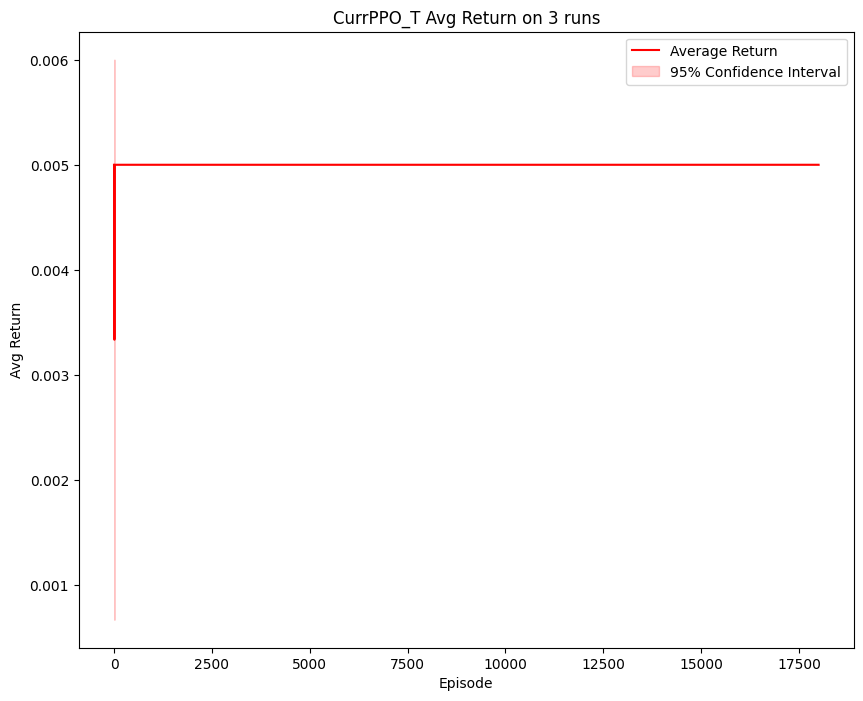

In [7]:
run_experiments(num_runs=num_runs)